## Import relevant packages


In [1]:
import numpy as np # ver 1.22.4
import pandas as pd # ver 2.2.1
import os
import glob
import matplotlib.pyplot as plt # ver 3.8.0
import seaborn as sns # ver 0.12.2
import tensorflow as tf # ver 2.10.0

## UTKFace dataset parsing


In [160]:
# DATA_DIR = ".../UTKFace"
great_grandparent_dir = os.path.join("../", "..", "..")
DATA_DIR = os.path.join(great_grandparent_dir, "UTKFace")
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP

({0: 'male', 1: 'female'}, {'male': 0, 'female': 1})

In [161]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None
    

<h3> Dataframe


In [159]:
#Code is messy because of how my files are structured.
great_grandparent_dir = os.path.join("../", "..", "..")
DATA_DIR = os.path.join(great_grandparent_dir, "UTKFace")
# os.listdir(DATA_DIR) 

In [163]:
# create a pandas data frame of images, age, gender and race
# print()

files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
# print("files",files)
attributes = list(map(parse_filepath, files))
# print("attributes", attributes)
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head(5)

../..\..\UTKFace\39_1_20170116174525125.jpg.chip.jpg
../..\..\UTKFace\61_1_20170109142408075.jpg.chip.jpg
../..\..\UTKFace\61_1_20170109150557335.jpg.chip.jpg


,age,gender,race,file
0,100.0,male,white,../..\..\UTKFace\100_0_0_20170112213500903.jpg...
1,100.0,male,white,../..\..\UTKFace\100_0_0_20170112215240346.jpg...
2,100.0,female,white,../..\..\UTKFace\100_1_0_20170110183726390.jpg...
3,100.0,female,white,../..\..\UTKFace\100_1_0_20170112213001988.jpg...
4,100.0,female,white,../..\..\UTKFace\100_1_0_20170112213303693.jpg...


In [5]:
# cut out all age data outside of 10 - 65 years old. Why did they do this? I speculate it's:
# 1, to artifically limit the ages it predicts to
# 2, there isn't enough data outside of those ranges to perform substantial training.
df = df[(df['age'] > 10) & (df['age'] < 65)] # (18529, 4)

# this may be one of the first things I undo actually. make it only 

In [6]:
# import h5py

# with h5py.File('./model_checkpoint/best_model.h5', 'r') as file:
#     print("Keys: %s" % file.keys())
#     model_weights_key = list(file.keys())[0]
#     # optimiser_values_key = list(file.keys())[1]
     
#     # Model weights
#     model_weights = list(file[model_weights_key])
#     #Optimiser weights
#     # optimiser_values = list(file[optimiser_values_key])
#     print("Model Weights: %s" % model_weights)
#     # print("Optimiser stuff: ", optimiser_values)


#     # Navigate through the groups and access the specific dataset for the conv2d kernel weights
#     conv2d_weights = file['model_weights']['conv2d']['conv2d']['kernel:0'][()]
    
#     # Now conv2d_weights contains the numpy array of the weights
#     print("Shape of 'conv2d' weights:", conv2d_weights.shape)
#     print("Weights for 'conv2d':", conv2d_weights)


Keys: <KeysViewHDF5 ['model_weights', 'optimizer_weights']>
Model Weights: ['age_output', 'batch_normalization', 'batch_normalization_1', 'batch_normalization_2', 'batch_normalization_3', 'batch_normalization_4', 'conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'dense', 'dense_1', 'dense_2', 'gender_output', 'global_max_pooling2d', 'input_1', 'max_pooling2d', 'max_pooling2d_1', 'max_pooling2d_2', 'max_pooling2d_3', 'max_pooling2d_4', 'race_output', 'top_level_model_weights']
Shape of 'conv2d' weights: (3, 3, 3, 32)
Weights for 'conv2d': [[[[-0.11724483 -0.1347773  -0.07682714 -0.02259798  0.09187897
    -0.04917165 -0.14353484 -0.06425358 -0.02395334  0.02702219
    -0.09778469  0.01513983  0.02242227 -0.0205462   0.15305194
     0.0580396  -0.10448089  0.09052771  0.14158133  0.01952916
    -0.09692919  0.05654911  0.00496747  0.10412586 -0.08635769
    -0.00951615 -0.1091877   0.09983656  0.07701898 -0.14476722
    -0.01205797  0.06546709]
   [-0.09528072  0.0732

## Inspecting Gender distribution for sampling purposes


In [7]:
for x in df['gender'].unique():
    print(x, df['gender'].value_counts()[x])
    
# male - 9791
# female - 8738
# sum => 18,529

male 9791
female 8738


In [165]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(11615, 4978, 7112, 116.0)

## OLD DATA GENERATOR FOR ORIGINAL MODEL


In [9]:

from keras.utils import to_categorical
from PIL import Image

def get_old_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

## Modified Data Generator


In [247]:

from keras.utils import to_categorical
from PIL import Image

# Modified function to remove race-related features.
# Modified to remove age normalisation
#TODO: Stratify data samples, make sure they sample equally from both genders.
#TODO: Refer to comments left at the bottom of the model tweaking section/right before "image prepocessing and model calling"

def get_new_data_generator(df, indices, for_training, batch_size=16):
    images, ages, genders = [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, gender = r['file'], r['age'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            # The new model makes use of linear activation function, so age data is not normalised.
            ages.append(age)
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []
        if not for_training:
            break

### Original CNN model


In [3]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

''' https://www.tensorflow.org/tutorials/images/transfer_learning#important_note_about_batchnormalization_layers
Important note about BatchNormalization layers
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.'''


def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

_ = Dense(units=128, activation='relu')(bottleneck)
age_output_sigmoid = Dense(units=1, activation='sigmoid', name='age_output_sigmoid')(_)

_ = Dense(units=128, activation='relu')(bottleneck)
age_output_linear = Dense(units=1, activation='linear', name='age_output_linear')(_)

# # Will remove race prediction after loading model weights.
# _ = Dense(units=128, activation='relu')(bottleneck)
# race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)


## Evaluation Function for re-usability


In [245]:
def evaluateModel(model):
    with tf.device('/gpu:0'):
        test_gen = get_new_data_generator(df, test_idx, for_training=False, batch_size=64)
        eval_result = dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//64)))
    eval_result

## Old model compilation, load and evaluation


In [12]:
# original_model = Model(inputs=input_layer, outputs=[age_output_sigmoid, race_output, gender_output])
# original_model.compile(optimizer='rmsprop', 
#               loss={'age_output_sigmoid': 'mse', 'gender_output': 'categorical_crossentropy'},
#               loss_weights={'age_output_sigmoid': 2., 'gender_output': 1.},
#               metrics={'age_output_sigmoid': ['mae', 'mse'], 'gender_output': 'accuracy'})

In [13]:
# load saved model weights into the model.
checkpoint_path = "./model_checkpoint/best_model.h5"
original_model.load_weights(checkpoint_path)


In [14]:
# #Old model evaluation
# with tf.device('/gpu:0'):
#     test_gen = get_old_data_generator(df, test_idx, for_training=False, batch_size=64)
#     eval_result = dict(zip(original_model.metrics_names, original_model.evaluate(test_gen, steps=len(test_idx)//64)))
# eval_result

#print:
# {'loss': 0.36984094977378845,
#  'age_output_loss': 0.09724269807338715,
#  'gender_output_loss': 0.17535553872585297,
#  'age_output_mae': 0.2679649293422699,
#  'age_output_mse': 0.09724269807338715,
#  'gender_output_accuracy': 0.9376816749572754}

86/86 [==============================] - 17s 134ms/step - loss: 0.3721 - age_output_sigmoid_loss: 0.0967 - gender_output_loss: 0.1787 - age_output_sigmoid_mae: 0.2672 - age_output_sigmoid_mse: 0.0967 - gender_output_accuracy: 0.9348


{}

In [15]:
#drop race column from dataset.
df = df.drop(['race', 'race_id'], axis='columns')
df

,age,gender,file,gender_id
188,11.0,male,../UTKFace\11_0_0_20170103200509559.jpg.chip.jpg,0
189,11.0,male,../UTKFace\11_0_0_20170103200824775.jpg.chip.jpg,0
190,11.0,male,../UTKFace\11_0_0_20170104012556563.jpg.chip.jpg,0
191,11.0,male,../UTKFace\11_0_0_20170110220408722.jpg.chip.jpg,0
192,11.0,male,../UTKFace\11_0_0_20170110220453002.jpg.chip.jpg,0
...,...,...,...,...
21078,64.0,female,../UTKFace\64_1_0_20170110160643876.jpg.chip.jpg,1
21079,64.0,female,../UTKFace\64_1_0_20170110160643892.jpg.chip.jpg,1
21080,64.0,female,../UTKFace\64_1_0_20170110182136419.jpg.chip.jpg,1
21081,64.0,female,../UTKFace\64_1_0_20170120223621126.jpg.chip.jpg,1


## New Model Weight copying, Compilation and Evaluation


In [4]:
# Instantiate model without race output found in original model
new_model = Model(inputs=input_layer, outputs=[age_output_linear, gender_output])

#hyperparameter tuning will come from these.
new_model.compile(optimizer='rmsprop', 
              loss={'age_output_linear': 'mse', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output_linear': 2., 'gender_output': 1.},
              metrics={'age_output_linear': ['mse', 'mae'], 'gender_output': 'accuracy'})

In [5]:
#checking new model aligns with my intentions (should only see two dense layers)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 196, 196, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 194, 194, 64  18496       ['conv2d[0][0]']                 
                                )                                                             

## Copied Weights over from old model to slighlty altered new model


In [46]:
# No need to rerun because weights have been saved to new model.See cell below
#Copy weights over from model 1
def copy_weights_from_old_model(old_model , target_model):
    for layer in target_model.layers:
        # added some conditions to handle layer name mismatch
        if layer.name=="dense_1":
            layer.set_weights(old_model.get_layer(name='dense').get_weights())

        elif layer.name=="age_output_linear":
            layer.set_weights(old_model.get_layer(name='age_output_sigmoid').get_weights())

        else:
            layer.set_weights(old_model.get_layer(name=layer.name).get_weights())

In [133]:
#Disabled as no longer utilised in later iterations of new_model.
# copy_weights_from_old_model(original_model, new_model)

new_model.load_weights('./model_checkpoint/linear_train_result.h5')

In [51]:


# Evaluating performance of new model loaded with copied weights
with tf.device('/gpu:0'):
    test_gen = get_new_data_generator(df, test_idx, for_training=False, batch_size=64)
    eval_result = dict(zip(new_model.metrics_names, new_model.evaluate(test_gen, steps=len(test_idx)//64)))
eval_result


#Results from copying weights over from original model to new model.
# age mae is so high due to the weights being optimised for sigmoid function.
# pre-training result, refer to "linear_train_result.h5" for updated weights. 
# {'loss': 2479.77880859375,
#  'age_output_linear_loss': 1239.5859375,
#  'gender_output_loss': 0.6064409017562866,
#  'age_output_linear_mse': 1239.5859375,
#  'age_output_linear_mae': 33.32229995727539,
#  'gender_output_accuracy': 0.8682776093482971}


#New accuracy scores: stored within "linear_train_result.h5"
# {'loss': 191.5492401123047,
#  'age_output_loss': 95.67698669433594,
#  'gender_output_loss': 0.1952550858259201,
#  'age_output_mse': 95.67698669433594,
#  'age_output_mae': 7.6476335525512695,
#  'gender_output_accuracy': 0.9282340407371521}

86/86 [==============================] - 11s 120ms/step - loss: 171.4924 - age_output_linear_loss: 85.6569 - gender_output_loss: 0.1787 - age_output_linear_mse: 85.6569 - age_output_linear_mae: 7.1945 - gender_output_accuracy: 0.9348


{'loss': 171.49244689941406,
 'age_output_linear_loss': 85.65689849853516,
 'gender_output_loss': 0.17871464788913727,
 'age_output_linear_mse': 85.65689849853516,
 'age_output_linear_mae': 7.194459438323975,
 'gender_output_accuracy': 0.9347746968269348}

In [19]:
original_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 196, 196, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 194, 194, 64  18496       ['conv2d[0][0]']                 
                                )                                                             

### Freezing Layer functions (as well as unfreeze function)


In [20]:
def freeze_all_except_age(chosen_model):
    for layer in chosen_model.layers: 
        layer.trainable = False
        if layer == chosen_model.layers[-4] or layer == chosen_model.layers[-2]:
            layer.trainable = True
    for layer in chosen_model.layers:
        print(layer, layer.trainable)

def freeze_all_except_dense_and_output(chosen_model):
    for layer in chosen_model.layers[:-4]: 
        layer.trainable = False
    layer.trainable = True
    for layer in chosen_model.layers:
        print(layer, layer.trainable)

def unfreeze_all_layers(chosen_model):
    for layer in chosen_model.layers[:]: 
        layer.trainable = True
    for layer in chosen_model.layers:
        print(layer, layer.trainable)

In [52]:
# freeze_all_except_dense_and_output(new_model) #Old method, using to replicate regress to mean error

freeze_all_except_age(new_model) #New method, currently working.

<keras.engine.input_layer.InputLayer object at 0x000001D6D6DCF1C0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001D6D6DCF190> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001D6D6DB2400> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D6D6DB2490> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D6D6D83CA0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001D6D6D83880> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D6D6D83BB0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D68B265F10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001D68B244610> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D6D6C3F760> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001D68B27F160> False
<keras.layers.convolutional.conv2d.Conv2D object at

In [23]:
# Uneccessary at this point.
# Checking accuracy after modifying activation function and before running training.
# with tf.device('/gpu:0'):
#     test_gen = get_new_data_generator(df, test_idx, for_training=False, batch_size=64)
#     eval_result = dict(zip(new_model.metrics_names, new_model.evaluate(test_gen, steps=len(test_idx)//64)))
# eval_result
    # {'loss': 2617.26318359375, 'age_output_loss': 1308.2847900390625, 'gender_output_loss': 0.6928508877754211, 'age_output_mse': 1308.2847900390625, 'gender_output_accuracy': 0.5243459343910217}

## Training/Tuning for New Model


In [25]:

from keras.callbacks import ModelCheckpoint, EarlyStopping


batch_size = 32
valid_batch_size = 32
train_gen = get_new_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_new_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='min'),
    ModelCheckpoint("./model_checkpoint/third_iteration", save_best_only=True, monitor='val_loss', mode='min')
]
with tf.device('/gpu:0'):
    #trying to replicate regression to mean with the simplified model
    # "new_model" should start from the point of being loaded with old model weights, being copied over,freeze all exc dense and out, and then trained improperly. *rmbr that you had model.fit, but you also overwrote model with new one before training.*
    history = new_model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=80,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)


Epoch 1/100
283/283 [==============================] - 53s 177ms/step - loss: 243.7299 - age_output_linear_loss: 121.6686 - gender_output_loss: 0.3926 - age_output_linear_mse: 121.6686 - age_output_linear_mae: 8.2916 - gender_output_accuracy: 0.8379 - val_loss: 433.5982 - val_age_output_linear_loss: 216.5893 - val_gender_output_loss: 0.4198 - val_age_output_linear_mse: 216.5893 - val_age_output_linear_mae: 11.4476 - val_gender_output_accuracy: 0.8164
Epoch 2/100
283/283 [==============================] - 49s 174ms/step - loss: 141.7224 - age_output_linear_loss: 70.6719 - gender_output_loss: 0.3786 - age_output_linear_mse: 70.6719 - age_output_linear_mae: 6.4792 - gender_output_accuracy: 0.8367 - val_loss: 273.7362 - val_age_output_linear_loss: 136.5827 - val_gender_output_loss: 0.5709 - val_age_output_linear_mse: 136.5827 - val_age_output_linear_mae: 8.8781 - val_gender_output_accuracy: 0.7314
Epoch 3/100
283/283 [==============================] - 49s 174ms/step - loss: 110.0585 - age_

KeyboardInterrupt: 

In [26]:

def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[0].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    #age_output_mse and age_output_loss would be the same thing because loss = {'age_output': 'mse'}
    axes[1].plot(history.history['age_output_mse'], label='Age Train MSE')
    axes[1].plot(history.history['val_age_output_mse'], label='Age Val MSE')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()  
    
    axes[2].plot(history.history['age_output_mae'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_mae'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()
    
    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

# 23 minutes 30 sec, 50 epochs.
# Early stopping: 14 minutes 30 sec, 31 epochs.


NameError: name 'history' is not defined

In [248]:
new_model.load_weights('./model_checkpoint/linear_train_result.h5')
test_gen = get_new_data_generator(df, test_idx, for_training=False, batch_size=64)
eval_result = dict(zip(new_model.metrics_names, new_model.evaluate(test_gen, steps=len(test_idx)//64)))
eval_result
#These are the values that I got when the model was regressing to mean. hopefully they are mirrored in the results below
# {'loss': 285.02716064453125,
#  'age_output_loss': 142.23597717285156,
#  'gender_output_loss': 0.5551707148551941,
#  'age_output_mse': 142.23597717285156,
#  'age_output_mae': 9.60434341430664,
#  'gender_output_accuracy': 0.7227470874786377}

1/1 [==============================] - 0s 451ms/step - loss: 1215.2186 - age_output_linear_loss: 607.3427 - gender_output_loss: 0.5333 - age_output_linear_mse: 607.3427 - age_output_linear_mae: 20.9007 - gender_output_accuracy: 0.7500


{'loss': 1215.2186279296875,
 'age_output_linear_loss': 607.3426513671875,
 'gender_output_loss': 0.5332878232002258,
 'age_output_linear_mse': 607.3426513671875,
 'age_output_linear_mae': 20.900745391845703,
 'gender_output_accuracy': 0.75}

## Inspecting training and validation datasets


In [ ]:
gen = get_new_data_generator(df, train_idx, for_training=True, batch_size=10)
batch1 = next(gen)
batch2 = next(gen)

# Investigating batches to ensure training is being randomised each iteration
print("Training Batch 1 ages:", batch1[1][0])
print("Training Batch 2 ages:", batch2[1][0])


gen = get_new_data_generator(df, valid_idx, for_training=True, batch_size=10)
batch1 = next(gen)
batch2 = next(gen)

# Investigating batches to ensure training is being randomised each iteration
print("Validation Batch 1 ages:", batch1[1][0])
print("Validation Batch 2 ages:", batch2[1][0])

Training Batch 1 ages: [35. 23. 26. 62. 54. 35. 57. 22. 25. 23.]
Training Batch 2 ages: [22. 26. 45. 24. 26. 23. 26. 32. 17. 12.]
Validation Batch 1 ages: [24. 26. 52. 46. 18. 56. 26. 40. 31. 51.]
Validation Batch 2 ages: [28. 50. 26. 25. 27. 33. 29. 35. 20. 36.]


In [ ]:
## going to reprocess the data, making effort to make data sample based on gender distribution. potentially also age so every training sample is spread evenly?

#Maybe binning the age variable into categories and treating the problem like a categorical problem is the solution? (if binning make sure to account for the 15-65 age spread given, maybe remove that restriction, it removed ~ 5k rows)



In [ ]:
#Commented out because uneccessary for what I'm doing right now
# test_gen = get_new_data_generator(df, test_idx, for_training=False, batch_size=64)
# eval_result = dict(zip(new_model.metrics_names, new_model.evaluate(test_gen, steps=len(test_idx)//64)))
# eval_result

# Results from the successful linear activation function adoption:
# {'loss': 191.5492401123047,
#  'age_output_loss': 95.67698669433594,
#  'gender_output_loss': 0.1952550858259201,
#  'age_output_mse': 95.67698669433594,
#  'age_output_mae': 7.6476335525512695,
#  'gender_output_accuracy': 0.9282340407371521}

86/86 [==============================] - 18s 212ms/step - loss: 191.5492 - age_output_loss: 95.6770 - gender_output_loss: 0.1953 - age_output_mse: 95.6770 - age_output_mae: 7.6476 - gender_output_accuracy: 0.9282


{'loss': 191.5492401123047,
 'age_output_loss': 95.67698669433594,
 'gender_output_loss': 0.1952550858259201,
 'age_output_mse': 95.67698669433594,
 'age_output_mae': 7.6476335525512695,
 'gender_output_accuracy': 0.9282340407371521}

## Image Preprocessing Function and Call Model Function


1/1 [==============================] - 0s 99ms/step


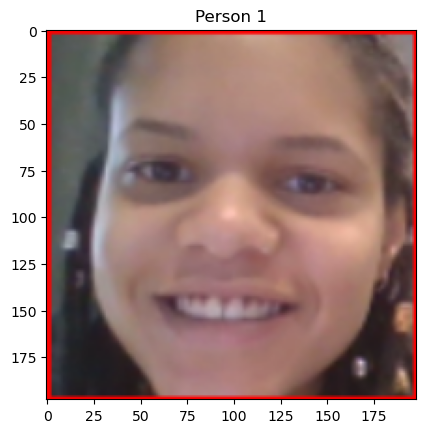

age_pred  :  23.887154
gender_pred  :  female


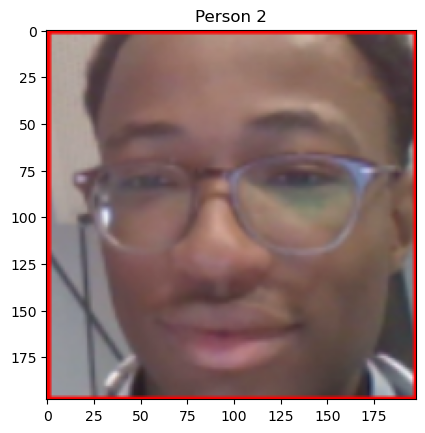

age_pred  :  27.644522
gender_pred  :  male


In [11]:
from keras.preprocessing import image
import cv2 
import json

IM_WIDTH = IM_HEIGHT = 198 

def predictor(img_cv):
    _ = image_processor(img_cv)    
    model_caller(_)

def image_processor(img_path): 

    # SOURCE: https://www.geeksforgeeks.org/cropping-faces-from-images-using-opencv-python/
    face_cascade = cv2.CascadeClassifier('./haarcascade/haarcascade_frontalface_alt2.xml')

    # Read image passed in.
    img_cv = cv2.imread(img_path)
    # plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    # plt.title('Unprocessed Image')
    # plt.show()
    
    
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)    
    # plt.imshow(gray)
    # plt.title('grayscale Image')
    # plt.show()
    
    # use opencv cascade classifier for face recognition
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) <= 0: #idk why im making it less than, not like it will detect negative faces or somthing
        raise ValueError("Error! No faces detected in the image.")

    # Draw rectangle around the faces and store the cropped face.
    # Update: Now handles MORE THAN ONE FACE!!!! 
    cropped_faces_list = []
    for (x, y, w, h) in faces: 
        cv2.rectangle(img_cv, (x, y), (x+w, y+h), (0, 0, 255), 2) 
        faces = img_cv[y:y + h, x:x + w]
        cropped_faces_list.append(faces)
    
    # plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    # plt.title(' Scanned Image ')
    # plt.show()
      
    # Take each face in the list, resize it.
    cropped_faces_list = [cv2.resize(face, (IM_WIDTH, IM_HEIGHT)) for face in cropped_faces_list]
    
    # for item in cropped_faces_list:
    #     item = cv2.resize(item, (IM_WIDTH, IM_HEIGHT))
    
    #All this does is print every face out in RGB. Redundant because of second function
    # for cropped_photo in cropped_faces_list:
    #     #This was flipping impossible to solve at first. dyk how much time it took me to find out their RGB channels are bloody reversed??!!!!???
    #     RGB_cropped_img_cv = cv2.cvtColor(cropped_photo, cv2.COLOR_BGR2RGB)
    #     plt.imshow(RGB_cropped_img_cv)
    #     plt.title(' RGB Processed Image ')
    #     plt.show()
    
    return cropped_faces_list 
#need to change structure of return value and model caller. make them iterate through list and return all information as json
    
    
def model_caller(cropped_faces_list): #TODO: for every cropped image in the list, normalise and replace. create batch and replace. call predictor.
    
    # initialiase empty dictionary variable {age, gender}
    list_of_predictions = []
    
    #normalisation and batch creation . . .
    for cropped_img_cv in cropped_faces_list:
        img_normalized = cropped_img_cv / 255.0
        img_batch = np.expand_dims(img_normalized, axis=0)
        
        # Make predictions
        predictions = new_model.predict(img_batch) # calculate a prediction and store it? then iterate and print them all
        
        # Extract age and gender predictions, store in data dictionary
        
        # Initalise a new dictionary of prediction values.
        data = {"age_pred" : 0.0,
        "gender_pred" : "" }
            
        # data['age_pred'] = predictions[0][0][0] * max_age
        #Modified to keep up with linear activation
        data['age_pred'] = predictions[0][0][0]
        data['gender_pred'] = ID_GENDER_MAP[np.argmax(predictions[1][0])]
        list_of_predictions.append(data)
        

    # Print predictions. TODO: Turn into for loop to print each set of values and the image.
    person_count = 1
    for (i,j) in zip(cropped_faces_list, list_of_predictions):
        plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
        plt.title(f'Person {person_count}')
        plt.show()
        # print(j)
        for key in j:
            print(key, " : ", j[key])
        person_count+=1
    return cropped_faces_list, list_of_predictions
 

def predict_with_manual_crop(img):
    _ = manual_crop(img)    
    predict_with_old_model(_)  

def manual_crop(img_path):
    # Load and display the original image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title('Image Library: Original Image')
    plt.show()

    # Crop image based on center of screen. focus on the central 50% of the camera capture.
    width, height = img.size
    print("current width: %i , current height: %i" % (width, height))
    new_width = 0.35 * width
    new_height = 0.80 * height
    print("new width: %i , new height: %i" % (new_width, new_height))
    
    left = (width - new_width)/2
    right = (width + new_width)/2
    top = (height - new_height)/2
    bottom = (height + new_height)/2
    print("left: %i , right: %i , top: %i , bottom: %i \n" % (left, right, top, bottom))

    img_cropped = img.crop((left, top, right, bottom))
    plt.imshow(img_cropped)
    plt.title('Image library: Cropped Image')
    plt.show()

    img_resize = img_cropped.resize((IM_WIDTH, IM_HEIGHT))
    
    plt.imshow(img_resize)
    plt.title('Image library: Processed Image')
    plt.show()
    
    return img_resize
    
def predict_with_old_model(resized_img):
    img_array = np.array(resized_img)
    img_normalized = img_array / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)
    prediction = original_model.predict(img_batch)
    
    plt.imshow(resized_img)
    plt.title('Result')
    plt.show()
    print("age:" , prediction[0][0][0] * 64.0 , ", gender:" , ID_GENDER_MAP[np.argmax(prediction[1][0])])



## A collection of local images used to test predictor
practice_img = "./personal_images/testing-cassy_(1).png" #Cassy and Me
# practice_img = "./personal_images/IMG-20240415-WA0006.jpg" #Multiple Faces Test
# practice_img = "./personal_images/IMG-20240411-WA0002.jpg" #Multiple Faces Test
# practice_img = "./personal_images/josh_pictures/josh_raw_straight.jpg" # Me
# practice_img = "./personal_images/jahnavi.jpg" # Sample image
# practice_img = "./personal_images/sofia.jpg" # Sofia img
# practice_img = "./personal_images/WIN_20240407_16_40_38_Pro.jpg" # Femi img

predictor(practice_img)
# predict_with_manual_crop(practice_img)


## New Dataframe


In [18]:
import os
import glob
import pandas as pd

ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())

##version_i contains augmented files with width and height shift. This caused problems with reading files since the faces were cropped close to the face.

def iterate_over_path_into_df(filepath):

    try:
        path, filename = os.path.split(filepath)
        # print(f"path: {path} filename: {filename}")
        
        filename, extension = os.path.splitext(filename)
        # print("file: ",filename)
        name, age, gender, _, _ = filename.split("_") ##version i and ii have two extra variables that I need to eliminate, while version ii has the correct naming convention (2 extra vars).
        ## There are up to three empty variables stored becauase of a naming mistake I made later on in the augmented dataset.
        
        # print(f"name: {name}, age: {int(age)}, gender: {ID_GENDER_MAP[int(gender)]}")
        return name, int(age), ID_GENDER_MAP[int(gender)]
    
    
    except Exception as e:
        print(f"Error with filepath: {filepath}")
        return None, None, None
    
#all files are jpg so no need for multi-type handling.

def backslash_swapper(list):
# swapping / to keep file path consistent.
    iterator = 0
    backslash = "\ "
    backslash = backslash.replace(" ","")
    for string in list:
        
        # string = string.replace(backslash,"/")
        # string = string.replace(" ","")
        
        string = string.replace("/","\ ")
        string = string.replace(" ","")
        for character in string:
            if character==" ": 
                character=""
        # print(f"list element at {iterator}: {list[iterator]}")
        list[iterator]=string
        if iterator < len(list):
            iterator+=1
    return list

In [185]:
#Modified function because of naming convention mistake causing errors with loading things into dataframe.
def personal_images_into_df(filepath):

    try:
        path, filename = os.path.split(filepath)
        # print(f"path: {path} filename: {filename}")
        
        filename, extension = os.path.splitext(filename)
        # print("file: ",filename)
        name, age, gender, _ = filename.split("_") 
        
        # print(f"name: {name}, age: {int(age)}, gender: {ID_GENDER_MAP[int(gender)]}")
        return name, int(age), ID_GENDER_MAP[int(gender)]
    
    
    except Exception as e:
        print(f"Error with filepath: {filepath}")
        return None, None, None

In [186]:
PATH = "./personal_images/cropped_photos" 
new_files = glob.glob(os.path.join(PATH, "*.jpg"))
new_files = backslash_swapper(new_files)
# print("new_files: ",new_files)
new_attributes = list(map(personal_images_into_df, new_files))
# print("new_attributes: ",new_attributes)

personal_img_df = pd.DataFrame(new_attributes)
personal_img_df['file'] = new_files
personal_img_df.columns = ['name','age', 'gender','file']
personal_img_df = personal_img_df.dropna()
personal_img_df.head(15)
print("shape: ",personal_img_df.shape)
personal_img_df.head()

shape:  (124, 4)


,name,age,gender,file
0,alexia,22,female,.\personal_images\cropped_photos\alexia_22_1_(...
1,alexia,22,female,.\personal_images\cropped_photos\alexia_22_1_(...
2,alexia,22,female,.\personal_images\cropped_photos\alexia_22_1_(...
3,alexia,22,female,.\personal_images\cropped_photos\alexia_22_1_(...
4,alexia,22,female,.\personal_images\cropped_photos\alexia_22_1_(...


(740, 4)

# Augmenting Personal Images Dataset


In [80]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

def augement_datset(path_read, path_out):
    if not os.path.exists(path_out):
        os.makedirs(path_out)
        
    augDataGenerator = ImageDataGenerator(
        # width_shift_range=[0.8,1.2],  
        # height_shift_range=[0.8,1.2], 
        rotation_range=45,      
        shear_range=0.2,        
        zoom_range=[0.8, 1.2],
        brightness_range=[0.5, 1.5],         
        horizontal_flip=True,  
        fill_mode='nearest'
    )
    for filename in os.listdir(path_read):
        if filename.endswith(".jpg"):
            img_path = os.path.join(path_read, filename)
            filename, extension = os.path.splitext(filename)
            name, age, gender, ignore = filename.split("_")
            title = str(name+"_"+age+"_"+gender)
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            
            count=1
            for batch in augDataGenerator.flow(img_array, batch_size=1, save_to_dir=path_out,save_prefix=title, save_format='jpg'):
                if count >= 20: #create x images for each image.
                    break
                count+=1

In [82]:
#Augmented data created sucessfully

input_path = './personal_images/cropped_photos'
output_path = './personal_images/augmented_photos_version_iii'
#version_ii contains augmented images without width and height shift due to face detection errors (see version-i comments).
#version_iii contained some brightness shifting and zooming.


# augement_datset(input_path, output_path)

## Feeding augmented data into new dataframe


In [238]:
SOURCE_PATH = "./personal_images/augmented_photos_version_iii"
files = glob.glob(os.path.join(SOURCE_PATH, "*.jpg"))
#Again fixing mistakes I made conventions of slashes in Paths and filenames
files = backslash_swapper(files) 
# print("files: ",files)

attributes = list(map(iterate_over_path_into_df, files))
# print("attributes: ",attributes)

aug_img_df = pd.DataFrame(attributes)
aug_img_df['file'] = files
aug_img_df.columns = ['name','age', 'gender','file']
aug_img_df = aug_img_df.dropna()
print("shape: ",aug_img_df.shape)
aug_img_df.head()

shape:  (2448, 4)


,name,age,gender,file
0,alexia,22,female,.\personal_images\augmented_photos_version_iii...
1,alexia,22,female,.\personal_images\augmented_photos_version_iii...
2,alexia,22,female,.\personal_images\augmented_photos_version_iii...
3,alexia,22,female,.\personal_images\augmented_photos_version_iii...
4,alexia,22,female,.\personal_images\augmented_photos_version_iii...


In [55]:
## Function to work with new data, virtually the exact same as the one used for the get_new_data_generator
from keras.utils import to_categorical
from PIL import Image
NEW_TRAIN_TEST_SPLIT = 0.9 #going to utilise 80/10/10 split for test and evaluation.

def get_new_augmented_data_generator(df, indices, for_training, batch_size=16):
    images, ages, genders = [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, gender = r['file'], r['age'], r['gender']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age)
            genders.append(gender)
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []
        if not for_training:
            break


In [239]:
p = np.random.permutation(len(aug_img_df))
aug_train_up_to = int(len(aug_img_df) * NEW_TRAIN_TEST_SPLIT)
aug_train_idx = p[:aug_train_up_to]
aug_test_idx = p[aug_train_up_to:]

# split aug_train_idx into training and validation set
aug_train_up_to = int(aug_train_up_to * 0.89) #90/10 split roughly equates to 80/10/10 split
aug_train_idx, aug_valid_idx = aug_train_idx[:aug_train_up_to], aug_train_idx[aug_train_up_to:]

# aug_img_df['gender_id'] = aug_img_df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
# aug_img_df['race_id'] = aug_img_df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = aug_img_df['age'].max()
len(aug_train_idx), len(aug_valid_idx), len(aug_test_idx), max_age

(1960, 243, 245, 22)

## Testing data gen to ensure functionality


In [220]:
gen = get_new_augmented_data_generator(aug_img_df, aug_train_idx, for_training=True, batch_size=10)
batch1 = next(gen)
batch2 = next(gen)

# Investigating batches to ensure training is being randomised each iteration
print("Training Batch 1 ages:", batch1[1][0])
print("Training Batch 2 ages:", batch2[1][0])


gen = get_new_augmented_data_generator(aug_img_df, aug_valid_idx, for_training=True, batch_size=10)
batch1 = next(gen)
batch2 = next(gen)

# Investigating batches to ensure training is being randomised each iteration
print("Validation Batch 1 ages:", batch1[1][0])
print("Validation Batch 2 ages:", batch2[1][0])

Training Batch 1 ages: [20 20 22 22 22 20 20 21 21 21]
Training Batch 2 ages: [21 22  7 22 22 21 21 21 22 20]
Validation Batch 1 ages: [20 21 20 20 20 22 20 22 21 20]
Validation Batch 2 ages: [20 21 21 21 20 20  7 22 21 20]


In [103]:
##Load model, compile, further tweaking, training with augmented dataset.
input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)
 
_ = Dense(units=128, activation='relu')(bottleneck)
print(_.name, "\n")
_ = Dropout(rate=0.5)(_)
print(_.name, "\n")
age_output_dropout = Dense(units=1, activation='linear', name='age_output_dropout')(_)
print("age_output_dropout: ",age_output_dropout, "\n")

_ = Dense(units=128, activation='relu')(bottleneck)
print(_, "\n")
_ = Dropout(rate=0.5)(_)
gender_output_dropout = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output_dropout')(_)


dense_37/Relu:0 

dropout_34/Identity:0 

age_output_dropout:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='age_output_dropout/BiasAdd:0', description="created by layer 'age_output_dropout'") 

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='dense_38/Relu:0', description="created by layer 'dense_38'") 



In [104]:
third_iteration_model = Model(inputs=input_layer, outputs=[age_output_dropout, gender_output_dropout])


In [263]:
third_iteration_model.compile(optimizer='adam', 
              loss={'age_output_dropout': 'mse', 'gender_output_dropout': 'categorical_crossentropy'},
              loss_weights={'age_output_dropout': 2., 'gender_output_dropout': 1.},
              metrics={'age_output_dropout': ['mse', 'mae'], 'gender_output_dropout': 'accuracy'})
third_iteration_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 196, 196, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 194, 194, 64  18496       ['conv2d_6[0][0]']               
                                )                                                          

In [106]:
for i in third_iteration_model.layers:
    print("layer type: ",i.__class__.__name__)

layer type:  InputLayer
layer type:  Conv2D
layer type:  Conv2D
layer type:  BatchNormalization
layer type:  MaxPooling2D
layer type:  Conv2D
layer type:  BatchNormalization
layer type:  MaxPooling2D
layer type:  Conv2D
layer type:  BatchNormalization
layer type:  MaxPooling2D
layer type:  Conv2D
layer type:  BatchNormalization
layer type:  MaxPooling2D
layer type:  Conv2D
layer type:  BatchNormalization
layer type:  MaxPooling2D
layer type:  GlobalMaxPooling2D
layer type:  Dense
layer type:  Dense
layer type:  Dropout
layer type:  Dropout
layer type:  Dense
layer type:  Dense


In [115]:
#All of this is hyper-specific code relying on the specific naming of the original model that has been compiled, the keras layers specifically being named in such a way that the whole notebook was run sequentially.

def altered_copy_weights_from_old_model(old_model , target_model):
    for layer_old, layer_new in zip(old_model.layers, target_model.layers):
        # print(f"layer_old: {layer_old.name} , layer_new: {layer_new.name} \n")
        
        # added some conditions to handle layer type mismatch
        if layer_new.__class__.__name__=="Dropout":
            #don't set anything, just skip over it.
            print("Dropout layer detected. skipped over.")
            layer_new.set_weights(target_model.get_layer(name=layer_new.name).get_weights())
            
        # elif layer_old.name=="dense_1":
        #     layer_new.set_weights(old_model.get_layer(name="dense_1").get_weights())
        # elif layer_old.name=="dense_2":
        #     layer_new.set_weights(old_model.get_layer(name="dense_2").get_weights())
        else:
            layer_new.set_weights(old_model.get_layer(name=layer_old.name).get_weights())
            print(f"copying {layer_old.name} from old model over to {layer_new.name} in new model \n")

In [116]:
altered_copy_weights_from_old_model(new_model, third_iteration_model)

copying input_1 from old model over to input_6 in new model 

copying conv2d from old model over to conv2d_6 in new model 

copying conv2d_1 from old model over to conv2d_7 in new model 

copying batch_normalization from old model over to batch_normalization_5 in new model 

copying max_pooling2d from old model over to max_pooling2d_5 in new model 

copying conv2d_2 from old model over to conv2d_8 in new model 

copying batch_normalization_1 from old model over to batch_normalization_6 in new model 

copying max_pooling2d_1 from old model over to max_pooling2d_6 in new model 

copying conv2d_3 from old model over to conv2d_9 in new model 

copying batch_normalization_2 from old model over to batch_normalization_7 in new model 

copying max_pooling2d_2 from old model over to max_pooling2d_7 in new model 

copying conv2d_4 from old model over to conv2d_10 in new model 

copying batch_normalization_3 from old model over to batch_normalization_8 in new model 

copying max_pooling2d_3 from 

In [262]:
third_iteration_model.summary() # connected as expected.

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 196, 196, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 194, 194, 64  18496       ['conv2d_6[0][0]']               
                                )                                                          

In [250]:
aug_img_df['gender_id'] = aug_img_df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
aug_img_df

,name,age,gender,file,gender_id
0,alexia,22,female,.\personal_images\augmented_photos_version_iii...,1
1,alexia,22,female,.\personal_images\augmented_photos_version_iii...,1
2,alexia,22,female,.\personal_images\augmented_photos_version_iii...,1
3,alexia,22,female,.\personal_images\augmented_photos_version_iii...,1
4,alexia,22,female,.\personal_images\augmented_photos_version_iii...,1
...,...,...,...,...,...
2443,tim,21,male,.\personal_images\augmented_photos_version_iii...,0
2444,tim,21,male,.\personal_images\augmented_photos_version_iii...,0
2445,tim,21,male,.\personal_images\augmented_photos_version_iii...,0
2446,tim,21,male,.\personal_images\augmented_photos_version_iii...,0


In [253]:
third_iteration_model.save_weights('./model_checkpoint/third_iteration.h5')

In [264]:
third_iteration_model.load_weights('./model_checkpoint/third_iteration.h5')
with tf.device('/gpu:0'):
    eval_gen = get_new_data_generator(aug_img_df, aug_test_idx, for_training=False, batch_size=64)
    
    if eval_gen is None:
        print("Error: The test data generator is broken.")
    
    print(third_iteration_model)
    print(eval_gen)
    
    eval_result = third_iteration_model.evaluate(eval_gen, steps=len(aug_test_idx)//64)
    print(".evaluate() result: ",eval_result)
    
    eval_result = dict(zip(third_iteration_model.metrics_names, eval_result))
    print(eval_result)

<generator object get_new_data_generator at 0x000001A5088CABA0>
3/3 [==============================] - 5s 970ms/step - loss: 817.6030 - age_output_dropout_loss: 408.4537 - gender_output_dropout_loss: 0.6956 - age_output_dropout_mse: 408.4537 - age_output_dropout_mae: 19.9636 - gender_output_dropout_accuracy: 0.2500
.evaluate() result:  [817.60302734375, 408.4537048339844, 0.6955878138542175, 408.4537048339844, 19.963640213012695, 0.25]
{'loss': 817.60302734375, 'age_output_dropout_loss': 408.4537048339844, 'gender_output_dropout_loss': 0.6955878138542175, 'age_output_dropout_mse': 408.4537048339844, 'age_output_dropout_mae': 19.963640213012695, 'gender_output_dropout_accuracy': 0.25}


## Training on Third Iteration Model


In [270]:
def freeze_all_except_dense_to_output(chosen_model):
    for layer in chosen_model.layers[:-5]: 
        layer.trainable = False
    layer.trainable = True
    for layer in chosen_model.layers:
        print(layer, layer.trainable)

def unfreeze_all_layers(chosen_model):
    for layer in chosen_model.layers[:]: 
        layer.trainable = True
    for layer in chosen_model.layers:
        print(layer, layer.trainable)

In [271]:
freeze_all_except_dense_to_output(third_iteration_model)

<keras.engine.input_layer.InputLayer object at 0x000001A417C85AC0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001A3FF8D78E0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001A4291B5E80> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A40332DBB0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001A23CA6B940> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001A3FF8D7880> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A4033276A0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001A2433EFF40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001A4291B52E0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A23C9C2D30> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001A35D29A5B0> False
<keras.layers.convolutional.conv2d.Conv2D object at

## Attempted Training with third iteration Model


In [274]:
# (Training Dropout Layers and Hyperparameter Tuning)

from keras.callbacks import ModelCheckpoint, EarlyStopping


batch_size = 32
valid_batch_size = 32
train_gen = get_new_data_generator(aug_img_df, aug_train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_new_data_generator(aug_img_df, aug_valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='min'),
    ModelCheckpoint("./model_checkpoint/third_iteration", save_best_only=True, monitor='val_loss', mode='min')
]
with tf.device('/gpu:0'):
    history = third_iteration_model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=70,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)


Epoch 1/70
362/362 [==============================] - ETA: 0s - loss: 35.2524 - age_output_dropout_loss: 17.3932 - gender_output_dropout_loss: 0.4660 - age_output_dropout_mse: 17.3932 - age_output_dropout_mae: 3.1866 - gender_output_dropout_accuracy: 0.8193

NotFoundError: {{function_node __wrapped__SaveV2_dtypes_118_device_/job:localhost/replica:0/task:0/device:CPU:0}} Failed to create a NewWriteableFile: ./model_checkpoint\third_iteration\variables\variables_temp/part-00000-of-00001.data-00000-of-00001.tempstate10638453514739530067 : The system cannot find the path specified.
; No such process [Op:SaveV2]

## Evaluation of Model


In [169]:
new_model.load_weights('./model_checkpoint/linear_train_result.h5')
test_gen = get_new_data_generator(df, test_idx, for_training=False, batch_size=64)
dict(zip(new_model.metrics_names, new_model.evaluate(test_gen, steps=len(test_idx)//64)))


111/111 [==============================] - 20s 180ms/step - loss: 426.8808 - age_output_linear_loss: 213.3132 - gender_output_loss: 0.2545 - age_output_linear_mse: 213.3132 - age_output_linear_mae: 10.9182 - gender_output_accuracy: 0.8964


{'loss': 426.88079833984375,
 'age_output_linear_loss': 213.3131866455078,
 'gender_output_loss': 0.2544654607772827,
 'age_output_linear_mse': 213.3131866455078,
 'age_output_linear_mae': 10.91819953918457,
 'gender_output_accuracy': 0.8963963985443115}

In [177]:
p = np.random.permutation(len(personal_img_df))
train_up_to = int(len(personal_img_df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
personal_test_idx = p[train_up_to:]

test_gen = get_new_data_generator(personal_img_df, personal_test_idx, for_training=False, batch_size=64)
x_test, (age_true, gender_true)= next(test_gen)

age_pred, gender_pred = new_model.predict_on_batch(x_test)

gender_true = gender_true.argmax(axis=-1)
gender_pred = gender_pred.argmax(axis=-1)
age_true = age_true
age_pred = age_pred

In [178]:
from sklearn.metrics import classification_report
print("\nClassification report for gender\n")
print(classification_report(gender_true, gender_pred))


Classification report for gender

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        41
           1       0.86      0.83      0.84        23

    accuracy                           0.89        64
   macro avg       0.88      0.88      0.88        64
weighted avg       0.89      0.89      0.89        64



## Evaluation of Model


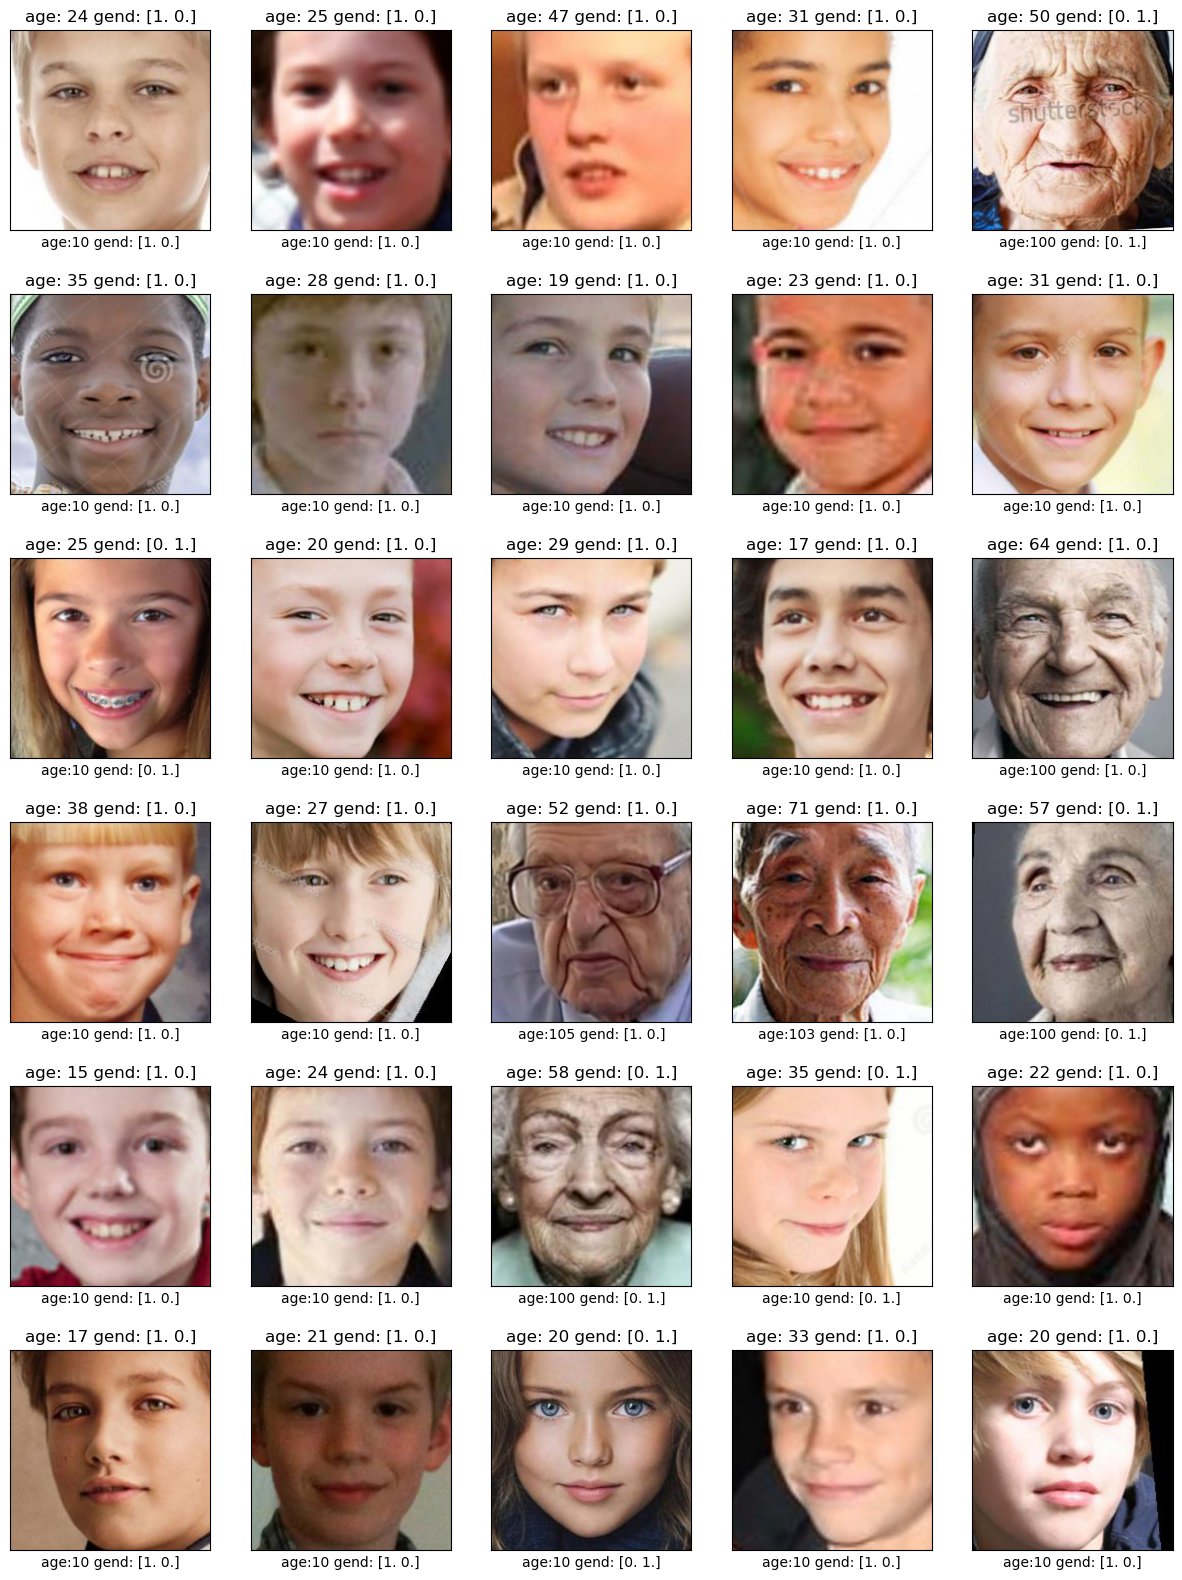

In [228]:
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    # print("i",i,"img_idx", img_idx)
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])

    prediction = str("age: " + str(int(age_pred[img_idx])) + " gend: " + str(gender_true[img_idx]))
    
    true_value = str("age:" + str(int(age_true[img_idx])) + " gend: " + str(gender_true[img_idx]) )
    
    ax.set_title(prediction)
    ax.set_xlabel(true_value)
    ax.set_xticks([])
    ax.set_yticks([])